Multiple APIs → pandas → Cleaning → SQLite → SQL → pandas → Visualization
merge population data from two sources:

REST Countries API: population by country

Simulated Metadata: extra info like continent, income level, and country code

Then:

Clean inconsistencies (missing values, mismatched country names)

Merge sources using safe joins

Calculate regional probabilities

Visualize and explain anomalies

In [3]:
# Messy data
import pandas as pd
import pprint

metadata = pd.DataFrame([
    {"country_name": "India", "region": "Asia", "income": "Lower middle", "code": "IN"},
    {"country_name": "Canada", "region": "Americas", "income": "High", "code": "CA"},
    {"country_name": "Germany", "region": "Europe", "income": "High", "code": "DE"},
    {"country_name": "Narnia", "region": "Fantasyland", "income": None, "code": "NA"},
    {"country_name": "Brazil", "region": None, "income": "Upper middle", "code": "BR"},
])

pprint.pprint(metadata)

  country_name       region        income code
0        India         Asia  Lower middle   IN
1       Canada     Americas          High   CA
2      Germany       Europe          High   DE
3       Narnia  Fantasyland          None   NA
4       Brazil         None  Upper middle   BR


In [ ]:
# updated region None value for Brazil to Americas
metadata.loc[metadata['country_name'] == 'Brazil','region'] = 'Americas'
metadata

,country_name,region,income,code
0,India,Asia,Lower middle,IN
1,Canada,Americas,High,CA
2,Germany,Europe,High,DE
3,Narnia,Fantasyland,None,NA
4,Brazil,Americas,Upper middle,BR


In [ ]:
# removed false country
error_country_row = metadata[metadata['country_name'] == 'Narnia']
print(error_country_row)

  country_name       region income code
3       Narnia  Fantasyland   None   NA


In [12]:
metadata.drop([3], axis=0, inplace=True)
print(metadata)

  country_name    region        income code
0        India      Asia  Lower middle   IN
1       Canada  Americas          High   CA
2      Germany    Europe          High   DE
4       Brazil  Americas  Upper middle   BR


In [26]:
# fetching data from other source API: https://restcountries.com/v3.1/all?fields=name,population,cca2

import requests
import pandas as pd
import pprint

url = 'https://restcountries.com/v3.1/all?fields=name,population,cca2'
response = requests.get(url)
data = response.json()

print(len(data))
print(data[0])

df = pd.json_normalize(data)

df = df[['cca2','population','name.common']]
df.columns = ['code','population','country_name']
df.head()

250
{'name': {'common': 'Moldova', 'official': 'Republic of Moldova', 'nativeName': {'ron': {'official': 'Republica Moldova', 'common': 'Moldova'}}}, 'cca2': 'MD', 'population': 2617820}


,code,population,country_name
0,MD,2617820,Moldova
1,KM,869595,Comoros
2,MY,32365998,Malaysia
3,DZ,44700000,Algeria
4,NF,2302,Norfolk Island


In [36]:
# merge to dataframe

df_merged = pd.merge(df, metadata, on='code', how='inner')
pprint.pprint(df_merged)

  code  population country_name_x country_name_y    region        income
0   CA    38005238         Canada         Canada  Americas          High
1   BR   212559409         Brazil         Brazil  Americas  Upper middle
2   IN  1380004385          India          India      Asia  Lower middle
3   DE    83240525        Germany        Germany    Europe          High


In [61]:
# Analysis
# World population from merged data
world_pop = df_merged['population'].sum()
print(f'Total population: {world_pop}')

# Probability of being born in high-income countries
high_income_pop = df_merged[df_merged['income']=='High']['population'].sum()
print(f'High Income Population: {high_income_pop}')

probability_high_income = high_income_pop / world_pop
print(f'probability that a person is from high income: {probability_high_income}')

# Average country population per income level
avg_pop_per_income = df_merged.groupby('income')['population'].mean().reset_index()
print(avg_pop_per_income)

Total population: 1713809557
High Income Population: 121245763
probability that a person is from high income: 0.07074634547623776
         income    population
0          High  6.062288e+07
1  Lower middle  1.380004e+09
2  Upper middle  2.125594e+08


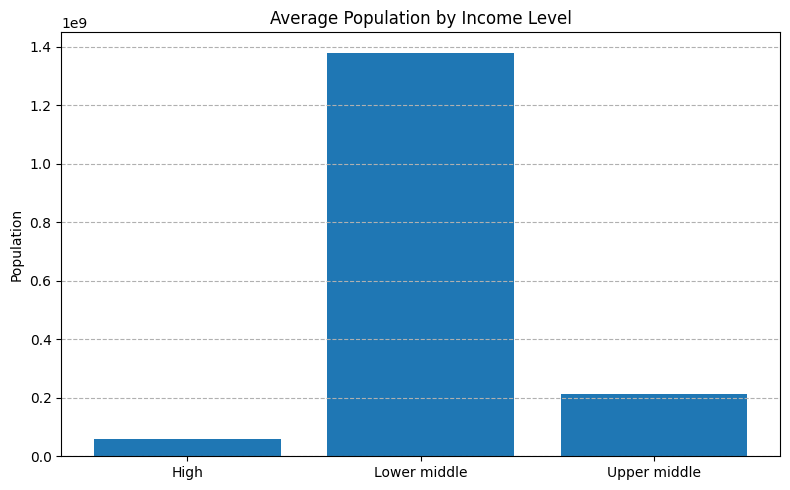

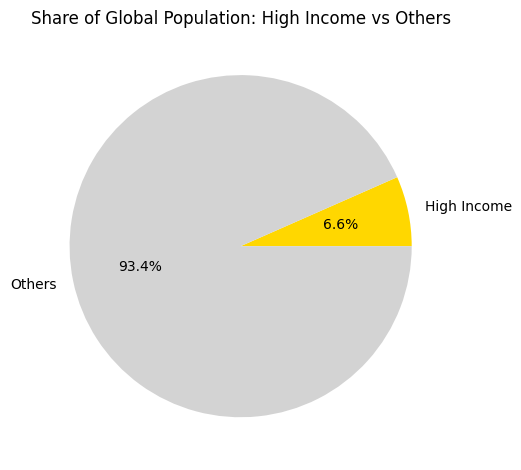

In [63]:
# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(avg_pop_per_income['income'],avg_pop_per_income['population'])
plt.title("Average Population by Income Level")
plt.ylabel("Population")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Pie chart: high income vs others
labels = ['High Income', 'Others']
sizes = [high_income_pop, world_pop]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['gold', 'lightgray'])
plt.title("Share of Global Population: High Income vs Others")
plt.tight_layout()
plt.show()

Only 6.6% of the world’s population lives in high-income countries Canada and Germany, despite dominating global economics.

Lower middle-income countries have higher average population per country, implying broader demographic pressures.

Merging by code avoids messy name mismatches — a clean join tactic used daily in production data pipelines.